In [338]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def add_missing_checkouts(df, checkout_label = 'checkout') :
    add_rows = df.groupby('customer_no').filter(lambda x : all(x['location'] != 'checkout'))
    add_rows['location'] = checkout_label
    return pd.concat([df, add_rows], ignore_index=True)


In [343]:
mon_df=pd.read_csv("monday.csv",sep=";")
tue_df=pd.read_csv("tuesday.csv",sep=";")
wed_df=pd.read_csv("wednesday.csv",sep=";")
thu_df=pd.read_csv("thursday.csv",sep=";")
fri_df=pd.read_csv("friday.csv",sep=";")

init_total_unique_customers = 0

for df in [mon_df, tue_df, wed_df, thu_df, fri_df]:
    init_total_unique_customers += len(df['customer_no'].unique())

    
init_total_unique_customers

7445

In [345]:
all_days_df = pd.concat([mon_df, tue_df, wed_df, thu_df, fri_df], ignore_index=True)

all_days_df

,timestamp,customer_no,location
0,2019-09-02 07:03:00,1,dairy
1,2019-09-02 07:03:00,2,dairy
2,2019-09-02 07:04:00,3,dairy
3,2019-09-02 07:04:00,4,dairy
4,2019-09-02 07:04:00,5,spices
...,...,...,...
24872,2019-09-06 21:50:00,1500,dairy
24873,2019-09-06 21:50:00,1507,checkout
24874,2019-09-06 21:50:00,1508,checkout
24875,2019-09-06 21:50:00,1509,drinks


In [ ]:

all_days_df = pd.DataFrame()

for df in [mon_df, tue_df, wed_df, thu_df, fri_df]:
    all_days_df = all_days_df.append(add_missing_checkouts(df))

all_days_df

0        1
16569    1
16591    1
16590    1
16589    1
        ..
8290     1
8289     1
8288     1
8287     1
24876    1
Length: 24877, dtype: int64

In [ ]:
mon_count=all_days_df.groupby("location")["customer_no"].count()
print("Total customer:", mon_count)


Total customer: location
checkout    7417
dairy       4679
drinks      3905
fruit       5122
spices      3754
Name: customer_no, dtype: int64


In [ ]:
all_days_df["timestamp"] = pd.to_datetime(all_days_df["timestamp"])
all_days_df['hour'] = all_days_df['timestamp'].dt.hour
all_days_df['weekday'] = all_days_df['timestamp'].dt.weekday

all_days_df.tail()


,timestamp,customer_no,location,hour,weekday
24872,2019-09-06 21:50:00,1500,dairy,21,4
24873,2019-09-06 21:50:00,1507,checkout,21,4
24874,2019-09-06 21:50:00,1508,checkout,21,4
24875,2019-09-06 21:50:00,1509,drinks,21,4
24876,2019-09-06 21:50:00,1510,spices,21,4


In [ ]:
all_days_df['customer_no']

0           1
1           2
2           3
3           4
4           5
         ... 
24872    1500
24873    1507
24874    1508
24875    1509
24876    1510
Name: customer_no, Length: 24877, dtype: int64

In [ ]:

max_customer_numbers = all_days_df.groupby(['weekday'])['customer_no'].max()

max_customer_numbers = max_customer_numbers.shift(1)
max_customer_numbers[0] = 0
max_customer_numbers = max_customer_numbers.astype(int).cumsum()



In [ ]:


# all_days_df.set_index("timestamp", inplace=True)

customers_column = all_days_df.apply(lambda x : x['customer_no'] + max_customer_numbers[x['weekday']], axis=1)
customers_column.name = "customer_no"


In [ ]:

all_days_df.update(customers_column)
all_days_df


,timestamp,customer_no,location,hour,weekday
0,2019-09-02 07:03:00,1,dairy,7,0
1,2019-09-02 07:03:00,2,dairy,7,0
2,2019-09-02 07:04:00,3,dairy,7,0
3,2019-09-02 07:04:00,4,dairy,7,0
4,2019-09-02 07:04:00,5,spices,7,0
...,...,...,...,...,...
24872,2019-09-06 21:50:00,7435,dairy,21,4
24873,2019-09-06 21:50:00,7442,checkout,21,4
24874,2019-09-06 21:50:00,7443,checkout,21,4
24875,2019-09-06 21:50:00,7444,drinks,21,4


timestamp            customer_no  location  hour  weekday  total_timespent  first_location
2019-09-02 21:38:00  1430         fruit     21    0        0 days 00:11:00  fruit             1
2019-09-05 21:43:00  5927         fruit     21    3        0 days 00:12:00  dairy             1
2019-09-06 21:39:00  7429         fruit     21    4        0 days 00:17:00  dairy             1
2019-09-06 21:35:00  7431         dairy     21    4        0 days 00:15:00  dairy             1
2019-09-06 21:33:00  7429         drinks    21    4        0 days 00:17:00  dairy             1
                                                                                             ..
2019-09-03 21:34:00  2858         drinks    21    1        0 days 00:21:00  drinks            1
2019-09-03 21:33:00  2858         spices    21    1        0 days 00:21:00  drinks            1
2019-09-03 21:29:00  2858         drinks    21    1        0 days 00:21:00  drinks            1
2019-09-02 21:50:00  1447         fruit     2

<AxesSubplot:xlabel='hour', ylabel='customer_no'>

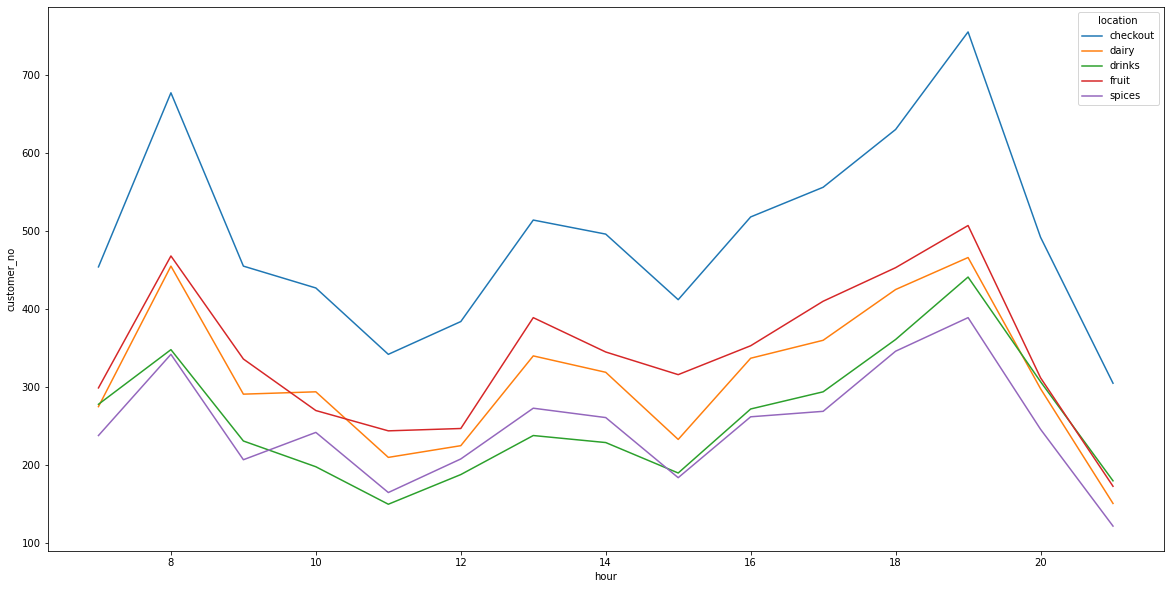

In [ ]:
customer_no_per_section_hour = all_days_df.groupby(["location", "hour"])['customer_no'].count()
customer_no_per_section_hour = customer_no_per_section_hour.reset_index()
plt.figure(figsize=(20,10))
sns.lineplot(data=customer_no_per_section_hour, x="hour", y="customer_no", hue="location")

In [ ]:

all_days_df_cust_no= all_days_df.reset_index().groupby("customer_no")["timestamp"].agg(lambda x : np.max(x)-np.min(x))

def get_timespent(customer_no, df):
    return df.loc[customer_no]

all_days_df['total_timespent'] =  all_days_df['customer_no'].apply(get_timespent, args=(all_days_df_cust_no,))



In [ ]:
all_days_df_cust_no= all_days_df.reset_index().groupby(["customer_no"]).first()
all_days_df_cust_no


,index,timestamp,location,hour,weekday,total_timespent
customer_no,,,,,,
1,0,2019-09-02 07:03:00,dairy,7,0,0 days 00:02:00
2,1,2019-09-02 07:03:00,dairy,7,0,0 days 00:03:00
3,2,2019-09-02 07:04:00,dairy,7,0,0 days 00:02:00
4,3,2019-09-02 07:04:00,dairy,7,0,0 days 00:04:00
5,4,2019-09-02 07:04:00,spices,7,0,0 days 00:01:00
...,...,...,...,...,...,...
7441,24864,2019-09-06 21:48:00,dairy,21,4,0 days 00:00:00
7442,24865,2019-09-06 21:48:00,dairy,21,4,0 days 00:02:00
7443,24866,2019-09-06 21:48:00,dairy,21,4,0 days 00:02:00


<AxesSubplot:xlabel='location', ylabel='Count'>

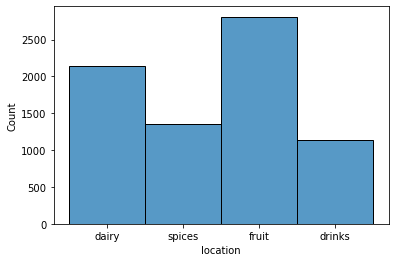

In [ ]:

sns.histplot(all_days_df_cust_no['location'])

In [ ]:
all_days_df_cust_no.loc[all_days_df_cust_no["location"] == 'checkout']['location'].count()

0

In [ ]:
all_days_df['first_location'] =  all_days_df['customer_no'].apply(lambda x : all_days_df_cust_no.loc[x]['location'])
all_days_df

,timestamp,customer_no,location,hour,weekday,total_timespent,first_location
0,2019-09-02 07:03:00,1,dairy,7,0,0 days 00:02:00,dairy
1,2019-09-02 07:03:00,2,dairy,7,0,0 days 00:03:00,dairy
2,2019-09-02 07:04:00,3,dairy,7,0,0 days 00:02:00,dairy
3,2019-09-02 07:04:00,4,dairy,7,0,0 days 00:04:00,dairy
4,2019-09-02 07:04:00,5,spices,7,0,0 days 00:01:00,spices
...,...,...,...,...,...,...,...
24872,2019-09-06 21:50:00,7435,dairy,21,4,0 days 00:09:00,dairy
24873,2019-09-06 21:50:00,7442,checkout,21,4,0 days 00:02:00,dairy
24874,2019-09-06 21:50:00,7443,checkout,21,4,0 days 00:02:00,dairy
24875,2019-09-06 21:50:00,7444,drinks,21,4,0 days 00:00:00,drinks


<AxesSubplot:xlabel='location', ylabel='Count'>

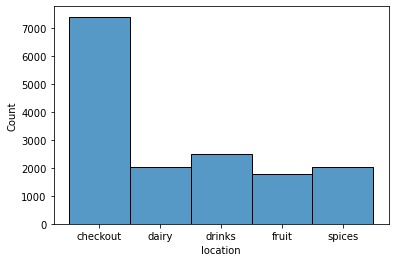

In [ ]:
sns.histplot(all_days_df.loc[all_days_df['first_location'] != all_days_df['location']]['location'])

<AxesSubplot:xlabel='location', ylabel='Count'>

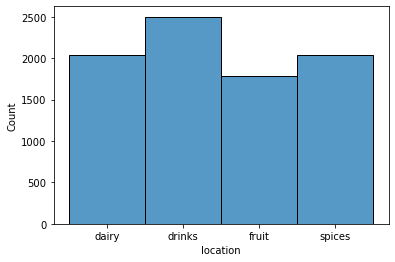

In [ ]:
sns.histplot(all_days_df.loc[(all_days_df['first_location'] != all_days_df['location']) & (all_days_df['location'] != 'checkout')]['location'])